In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from datetime import timedelta 
import gc
import os
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Ridge
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/grocery-data/oil.csv
/kaggle/input/grocery-data/items.csv
/kaggle/input/grocery-data/sample_submission.csv
/kaggle/input/grocery-data/holidays_events.csv
/kaggle/input/grocery-data/stores.csv
/kaggle/input/grocery-data/train.csv
/kaggle/input/grocery-data/test.csv
/kaggle/input/grocery-data/transactions.csv


In [2]:
train = pd.read_csv('/kaggle/input/grocery-data/train.csv')
test = pd.read_csv('/kaggle/input/grocery-data/test.csv')
holidays_events = pd.read_csv('/kaggle/input/grocery-data/holidays_events.csv')
items = pd.read_csv('/kaggle/input/grocery-data/items.csv')
oil = pd.read_csv('/kaggle/input/grocery-data/oil.csv')
stores = pd.read_csv('/kaggle/input/grocery-data/stores.csv')
transactions = pd.read_csv('/kaggle/input/grocery-data/transactions.csv')


# Data Exploration and Preprocessing
* Step 1: Merging DataFrames

In [3]:
train_stores = train.merge(stores, on='store_nbr')
train_stores_oil = train_stores.merge(oil, on='date')
train_stores_oil_transactions = train_stores_oil.merge(transactions, on=['date', 'store_nbr'])
train_stores_oil_transactions_hol = train_stores_oil_transactions.merge(holidays_events, on='date')
data_df = train_stores_oil_transactions_hol.copy(deep=True)


* Step 2: Converting Boolean Columns to Integers

In [4]:
data_df['onpromotion'] = data_df['onpromotion'].astype(int)
data_df['transferred'] = data_df['transferred'].astype(int)


* Step 3: Renaming Columns

In [5]:
data_df.rename(columns={'type_x': 'st_type', 'type_y': 'hol_type'}, inplace=True)


* Step 4: Dropping Unnecessary Columns

In [6]:
if 'id' in data_df.columns:
    data_df.drop(columns=['id'], inplace=True)

* Step 5: Converting Dates to Ordinal

In [7]:
data_df['date'] = pd.to_datetime(data_df['date'])
data_df['date'] = data_df['date'].apply(lambda x: x.toordinal())

# Splitting Data into Numerical, Categorical, and Date Columns

In [8]:
df_ = data_df.drop(['date'], axis=1)
cols = df_.columns
num_cols = df_._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))

data_num_df = data_df[num_cols]
data_cat_df = data_df[cat_cols]
data_date_df = data_df['date']

# Processing Numerical Data
* Step 1: Imputing Missing Values

In [9]:
imputer = SimpleImputer(strategy="mean", copy=True)
num_imp = imputer.fit_transform(data_num_df)
data_num_df = pd.DataFrame(num_imp, columns=data_num_df.columns, index=data_num_df.index)

* Step 2: Applying Standard Scaling

In [10]:
scaler = StandardScaler()
num_scaled = scaler.fit_transform(data_num_df)
data_num_df = pd.DataFrame(num_scaled, columns=data_num_df.columns, index=data_num_df.index)


# Processing Categorical Data
* Step 1: One-Hot Encoding

In [58]:
cat_encoder = OneHotEncoder(sparse_output=False)
data_cat_1hot = cat_encoder.fit_transform(data_cat_df)

data_cat_df = pd.DataFrame(data_cat_1hot, columns=cat_encoder.get_feature_names_out())

In [59]:
processed_data = data_num_df.join(data_cat_df)
processed_data = processed_data.join(data_date_df)
processed_data.head()

,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions,transferred,st_type_A_0.0,st_type_A_1.0,st_type_B_0.0,...,hol_type_Additional_1.0,hol_type_Bridge_0.0,hol_type_Bridge_1.0,hol_type_Event_0.0,hol_type_Event_1.0,hol_type_Holiday_0.0,hol_type_Holiday_1.0,hol_type_Transfer_0.0,hol_type_Transfer_1.0,date
0,-0.127903,-0.325920,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,734869
1,-0.127903,-0.325920,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,734869
2,-0.127903,-0.324316,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,734869
3,-0.127903,0.323701,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,734869
4,-0.127903,-0.325920,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,734869


In [60]:
X = processed_data.drop(['sales', 'transactions'], axis=1)
Y = processed_data[['sales', 'transactions']]

In [61]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


In [62]:
from sklearn.linear_model import LinearRegression,SGDRegressor,ElasticNet,Ridge,RidgeCV, LassoCV,Lasso
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error


def checkModelPerformance(model):
    model.fit(x_train.values, y_train.values)
    
    pred = model.predict(x_test.values)
    
    print("mean_squared_error: ",np.sqrt(mean_squared_error(y_test.values, pred))) 
    print("mean_absolute_error: ", np.sqrt(mean_absolute_error(y_test.values, pred)))

In [16]:
print("LinearRegression")
checkModelPerformance(LinearRegression())


LinearRegression
mean_squared_error:  0.6177941422986941
mean_absolute_error:  0.5334723612588516


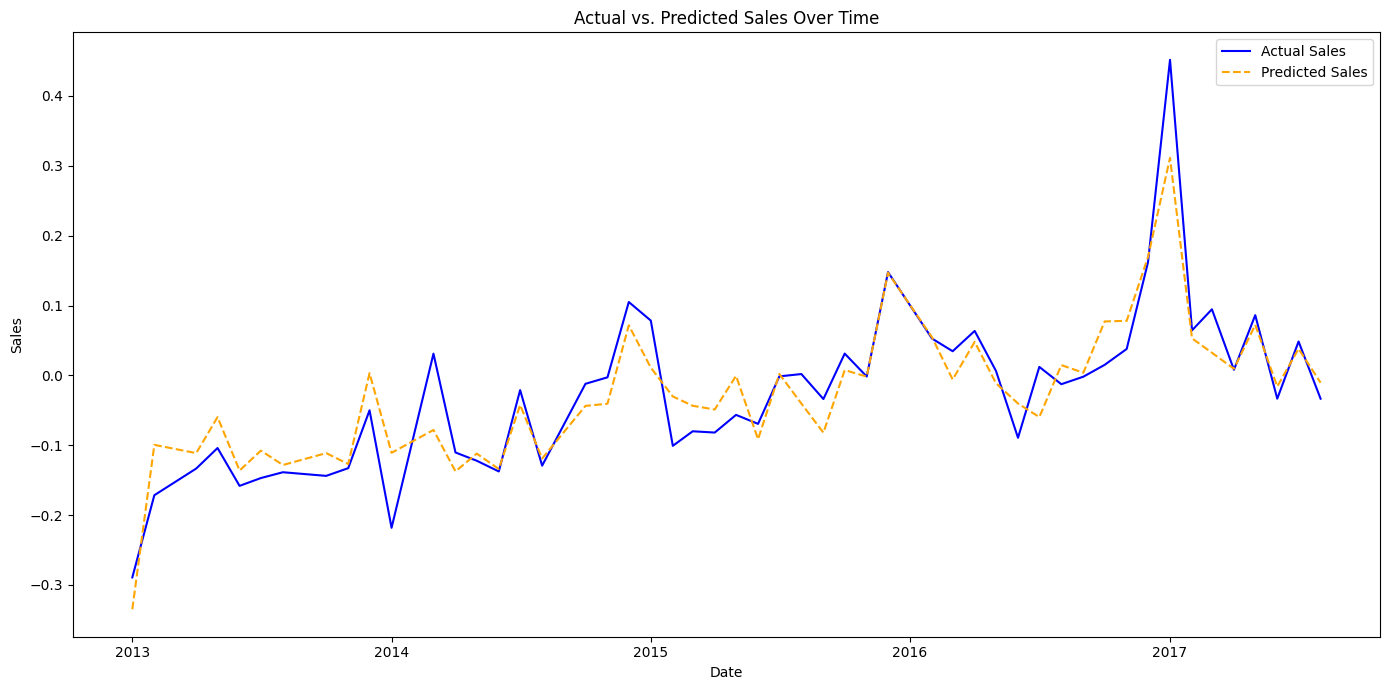

In [68]:
import pandas as pd
import matplotlib.pyplot as plt



def plot_sales(model, x_train, x_test, y_train, y_test):
    # Fit the model
    model.fit(x_train, y_train['sales'])
    sales_predictions = model.predict(x_test)

    # Create a DataFrame with actual and predicted sales
    results_df = pd.DataFrame({
        'date': x_test['date'].apply(lambda x: pd.Timestamp.fromordinal(x)),
        'actual_sales': y_test['sales'],
        'predicted_sales': sales_predictions
    })

    # Aggregate the data by month
    results_df['month'] = results_df['date'].dt.to_period('M')
    monthly_data = results_df.groupby('month').agg({
        'actual_sales': 'mean',
        'predicted_sales': 'mean'
    }).reset_index()

    # Convert period to timestamp for plotting
    monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

    # Plot the results
    plt.figure(figsize=(14, 7))

    # Plot both actual and predicted sales
    plt.plot(monthly_data['month'], monthly_data['actual_sales'], label='Actual Sales', color='blue')
    plt.plot(monthly_data['month'], monthly_data['predicted_sales'], label='Predicted Sales', color='orange', linestyle='--')
    
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Actual vs. Predicted Sales Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with a linear regression model
from sklearn.linear_model import LinearRegression

# Define the model
linear_regression_model = LinearRegression()

# Call the function
plot_sales(linear_regression_model, x_train, x_test, y_train, y_test)


In [65]:
# Lasso Regression
print("lasso regression ")
checkModelPerformance(Lasso(alpha=0.1))

# Ridge Regression
print("Ridge regression ")
checkModelPerformance(Ridge(alpha=1.0))

lasso regression 
mean_squared_error:  0.8593955727491082
mean_absolute_error:  0.671340465859099
Ridge regression 
mean_squared_error:  0.6177900376640371
mean_absolute_error:  0.533505170442124


# crosss validation for ridge and lasso

In [18]:
from sklearn.linear_model import RidgeCV, MultiTaskLassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


ridge_model_cv = RidgeCV(alphas=[0.01, 0.1, 1])
ridge_model_cv.fit(x_train.values, y_train.values)
y_pred_ridge = ridge_model_cv.predict(x_test.values)
mse_ridge = mean_squared_error(y_test.values, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test.values, y_pred_ridge)
print("Best alpha for Ridge regression:", ridge_model_cv.alpha_)
print("Mean Squared Error (MSE) - Ridge Regression:", mse_ridge)
print("Mean Absolute Error (MAE) - Ridge Regression:", mae_ridge)


lasso_model_cv = MultiTaskLassoCV(alphas=[0.01, 0.1, 1])
lasso_model_cv.fit(x_train.values, y_train.values)
y_pred_lasso = lasso_model_cv.predict(x_test.values)
mse_lasso = mean_squared_error(y_test.values, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test.values, y_pred_lasso)
print("Best alpha for Lasso regression:", lasso_model_cv.alpha_)
print("Mean Squared Error (MSE) - Lasso Regression:", mse_lasso)
print("Mean Absolute Error (MAE) - Lasso Regression:", mae_lasso)


Best alpha for Ridge regression: 1.0
Mean Squared Error (MSE) - Ridge Regression: 0.3816643129537342
Mean Absolute Error (MAE) - Ridge Regression: 0.2846180550002778
Best alpha for Lasso regression: 0.01
Mean Squared Error (MSE) - Lasso Regression: 0.44795413385152427
Mean Absolute Error (MAE) - Lasso Regression: 0.3259010631964633


**ElasticNet regression**

In [20]:
print("ElasticNet regression ")
checkModelPerformance(ElasticNet())

ElasticNet regression 
mean_squared_error:  1.0271515414300663
mean_absolute_error:  0.7722654259544043


# Cross validation for ElasticNet

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9],  
    'max_iter': [100, 500]  
}

enet = ElasticNet()
elasticnet_cv = GridSearchCV(enet, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
elasticnet_cv.fit(x_train.values, y_train.values)
best_params = elasticnet_cv.best_params_
print("Best Hyperparameters:", best_params)
y_pred = elasticnet_cv.predict(x_test.values)
mse = mean_squared_error(y_test.values, y_pred)
mae = mean_absolute_error(y_test.values, y_pred)
print("Mean Squared Error =", mse)
print("Mean Absolute Error (MAE):", mae)


Best Hyperparameters: {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}
Mean Squared Error = 0.413785375420613
Mean Absolute Error (MAE): 0.2867417283905768


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.434e+02, tolerance: 2.259e+01
  model = cd_fast.enet_coordinate_descent(


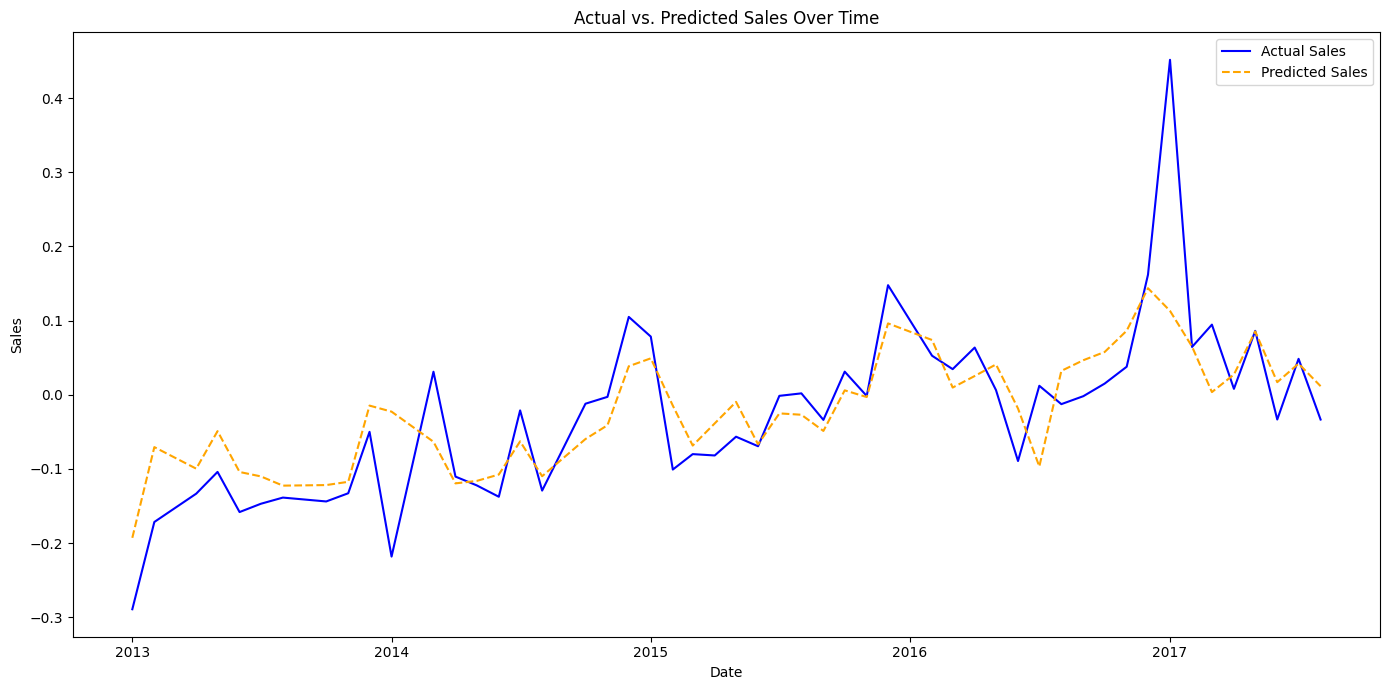

In [69]:
elasticNet_model=ElasticNet(alpha=0.01,l1_ratio=0.1,max_iter=100)
elasticNet_model.fit(x_train.values,y_train.values)

# Feature importance for each regression model:

In [43]:
def print_top_features(model, model_name, n_top_features=30):
    feature_importance = np.abs(model.coef_)
    sorted_idx = np.argsort(feature_importance)[::-1][:n_top_features]
    top_features = X.columns[sorted_idx]
    top_importance = feature_importance[sorted_idx]
    
    print(f"\nTop {n_top_features} Features - {model_name} Feature Importance")
    for feature, importance in zip(top_features, top_importance):
        print(f"{feature}: {importance:.6f}")


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01,l1_ratio=0.1,max_iter=100)
}

for model_name, model in models.items():
    model.fit(x_train, y_train['sales'])  
    print_top_features(model, model_name)


Top 30 Features - Linear Regression Feature Importance
st_type_A: 177272602.801306
st_type_E: 177272602.349927
st_type_B: 177272602.248598
st_type_D: 177272602.228343
st_type_C: 177272602.142473
state_Bolivar: 50955564.384160
state_Cotopaxi: 43056369.603249
city_Cayambe: 35776648.641902
city_Quito: 35776648.619799
city_Guaranda: 32509133.791067
city_Latacunga: 24609938.941268
state_Chimborazo: 18455698.958399
state_Guayas: 18186615.073918
state_Pichincha: 17330217.948430
city_Santo Domingo: 13234232.842978
state_Azuay: 12731984.674049
state_El Oro: 12417508.387573
city_Loja: 12377479.030011
city_Esmeraldas: 12310071.594481
state_Santa Elena: 11509826.357083
city_Ambato: 11229698.298370
state_Manabi: 10126706.780471
city_Puyo: 9545626.623190
city_Ibarra: 9389001.856113
state_Los Rios: 9307320.794848
city_Quevedo: 9139109.956620
city_Babahoyo: 9139109.869854
state_Imbabura: 9057428.781301
state_Pastaza: 8900804.224670
city_El Carmen: 8319723.928164

Top 30 Features - Ridge Regression Fe

# Tree Models

**decision tree regressor with cross validation**

In [25]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


hyperparameters = {
    'max_depth': randint(1, 6), 
    'min_samples_leaf': randint(5, 20)  
}

decision_tree = DecisionTreeRegressor(random_state=42)
random_search = RandomizedSearchCV(
    decision_tree,
    param_distributions=hyperparameters,
    n_iter=10,  
    cv=3, 
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1  
)
random_search.fit(x_train.values, y_train.values)
print('Best Parameters:', random_search.best_params_)
y_pred = random_search.best_estimator_.predict(x_test.values)
mse = mean_squared_error(y_test.values, y_pred)
mae = mean_absolute_error(y_test.values, y_pred)
print("Mean Squared Error (MSE) For Decision Tree:", mse)
print("Mean Absolute Error (MAE):", mae)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 9}
Mean Squared Error (MSE) For Decision Tree: 0.44587003757843513
Mean Absolute Error (MAE): 0.33521610066047974


In [26]:
decision_treeCV=DecisionTreeRegressor(**random_search.best_params_) #The **unpacks the dictionnary
decision_treeCV.fit(x_train.values,y_train.values)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=9)

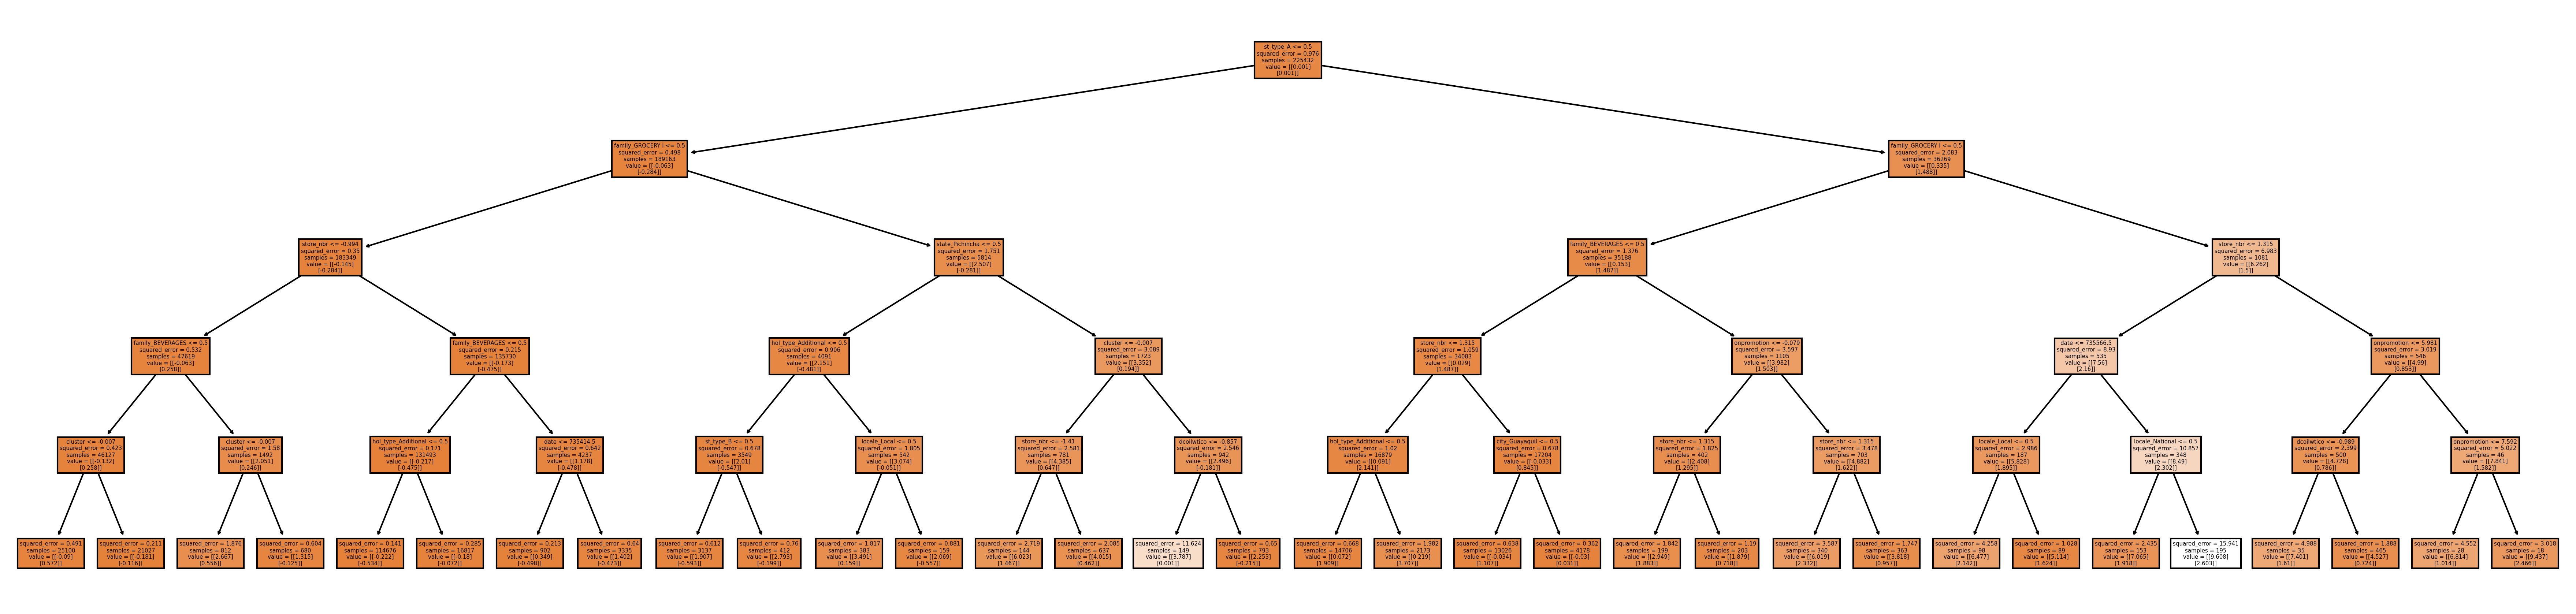

In [27]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30,7), dpi=300)
plot_tree(decision_treeCV, filled=True, feature_names=x_train.columns)
plt.show()

# Random Forest with cross validation

In [ ]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor(random_state=42)
 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(x_train.values, y_train.values)
print('Best Parameters:', grid_search.best_params_)
y_pred = grid_search.predict(x_test.values)
mse = mean_squared_error(y_test.values, y_pred)
mae = mean_absolute_error(y_test.values, y_pred)
print("Mean Squared Error (MSE) For Random Forest:", mse_rf)
print("Mean Absolute Error (MAE):", mae_rf)

In [28]:
print('Best Parameters:', {'max_features': 2, 'n_estimators': 30})

Best Parameters: {'max_features': 2, 'n_estimators': 30}


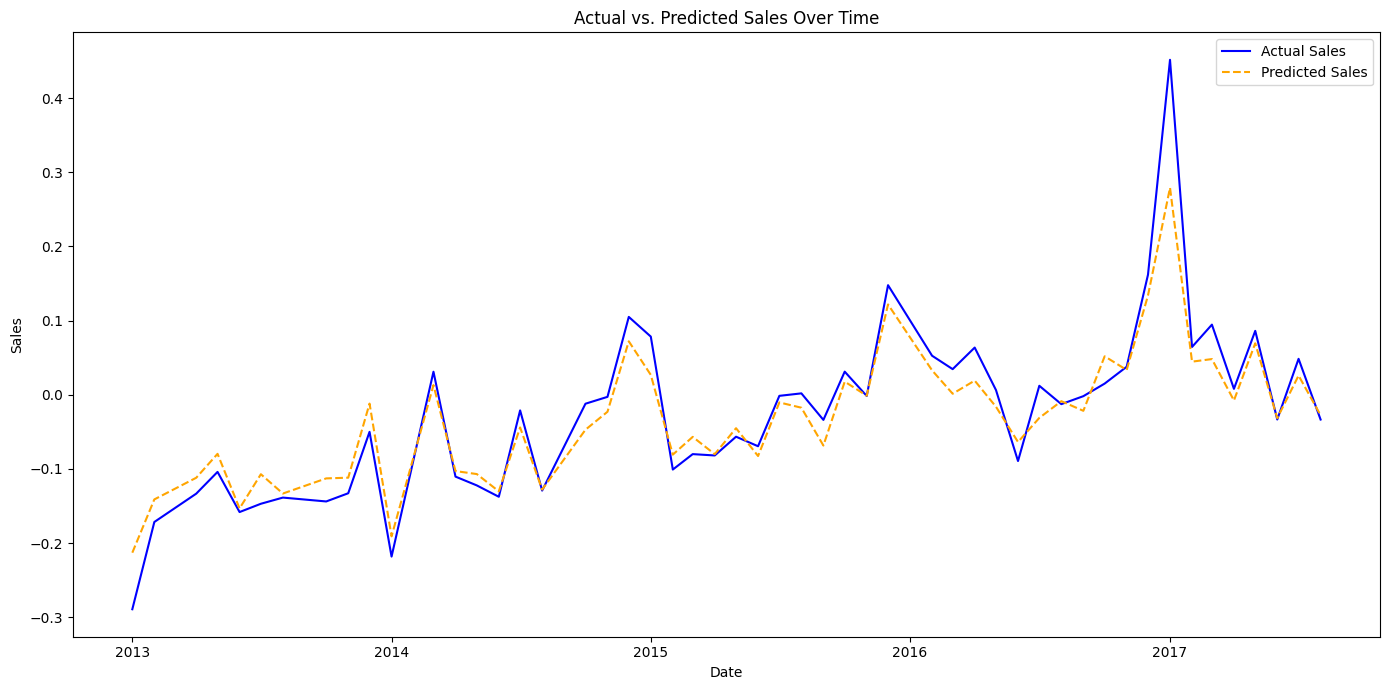

KeyboardInterrupt: 

In [70]:
RandomForestCV=RandomForestRegressor(max_features=2, n_estimators=30, random_state=42) 
plot_sales(RandomForestCV, x_train, x_test, y_train, y_test)
RandomForestCV.fit(x_train.values,y_train.values)
y_pred = RandomForestCV.predict(x_test.values)
mse = mean_squared_error(y_test.values, y_pred)
mae = mean_absolute_error(y_test.values, y_pred)
print("Mean Squared Error (MSE) For Random Forest:", mse)
print("Mean Absolute Error (MAE):", mae)

# feature importance for tree models 

In [39]:
def print_top_features_tree(model, model_name, n_top_features=30):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1][:n_top_features]
    top_features = X.columns[sorted_idx]
    top_importance = feature_importance[sorted_idx]
    
    print(f"\nTop {n_top_features} Features - {model_name} Feature Importance")
    for feature, importance in zip(top_features, top_importance):
        print(f"{feature}: {importance:.6f}")

print_top_features_tree(decision_treeCV, 'decision_treeCV')
print_top_features_tree(RandomForestCV, 'RandomForestCV')


Top 30 Features - decision_treeCV Feature Importance
st_type_A: 0.360353
family_GROCERY I: 0.282717
store_nbr: 0.136536
family_BEVERAGES: 0.113417
hol_type_Additional: 0.035736
cluster: 0.029340
city_Guayaquil: 0.013136
state_Pichincha: 0.008261
onpromotion: 0.007632
date: 0.005993
dcoilwtico: 0.002137
locale_National: 0.002133
locale_Local: 0.001379
st_type_B: 0.001229
description_Traslado Batalla de Pichincha: 0.000000
family_PRODUCE: 0.000000
city_Daule: 0.000000
city_Cuenca: 0.000000
city_Cayambe: 0.000000
city_Babahoyo: 0.000000
city_Ambato: 0.000000
family_SEAFOOD: 0.000000
family_SCHOOL AND OFFICE SUPPLIES: 0.000000
family_POULTRY: 0.000000
family_PREPARED FOODS: 0.000000
city_Esmeraldas: 0.000000
family_PLAYERS AND ELECTRONICS: 0.000000
family_PET SUPPLIES: 0.000000
family_PERSONAL CARE: 0.000000
family_MEATS: 0.000000

Top 30 Features - RandomForestCV Feature Importance
family_GROCERY I: 0.121219
store_nbr: 0.120173
onpromotion: 0.107087
st_type_A: 0.084145
cluster: 0.061758


In [44]:
processed_data

,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions,transferred,st_type_A,st_type_B,st_type_C,...,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo,hol_type_Additional,hol_type_Bridge,hol_type_Event,hol_type_Holiday,hol_type_Transfer,date
0,-0.127903,-0.325920,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734869
1,-0.127903,-0.325920,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734869
2,-0.127903,-0.324316,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734869
3,-0.127903,0.323701,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734869
4,-0.127903,-0.325920,-0.240273,-1.597692,1.170981e-15,-0.917916,-0.210745,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,734869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,-1.153863,0.025463,-0.240273,-0.536977,-6.801297e-01,0.400713,-0.210745,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,736556
322043,-1.153863,-0.201969,-0.175807,-0.536977,-6.801297e-01,0.400713,-0.210745,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,736556
322044,-1.153863,1.614708,9.300684,-0.536977,-6.801297e-01,0.400713,-0.210745,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,736556
322045,-1.153863,-0.228878,0.275454,-0.536977,-6.801297e-01,0.400713,-0.210745,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,736556


# Process the Test Data for Predictions

In [ ]:
def preprocess_test_data(test_df, scaler, cat_encoder, imputer):
    # Drop the 'id' column
    test_df = test_df.drop(columns=['id'])
    
    # Convert dates to ordinal
    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df['date'] = test_df['date'].apply(lambda x: x.toordinal())

    # Split the data into numerical and categorical components
    df_ = test_df.drop(['date'], axis=1)
    cols = df_.columns
    num_cols = df_._get_numeric_data().columns
    cat_cols = list(set(cols) - set(num_cols))

    data_num_df = test_df[num_cols]
    data_cat_df = test_df[cat_cols]
    data_date_df = test_df['date']

    # Impute missing values and scale numerical data
    num_imp = imputer.transform(data_num_df)
    data_num_df = pd.DataFrame(num_imp, columns=data_num_df.columns, index=data_num_df.index)

    num_scaled = scaler.transform(data_num_df)
    data_num_df = pd.DataFrame(num_scaled, columns=data_num_df.columns, index=data_num_df.index)

    # One-hot encode categorical data
    data_cat_1hot = cat_encoder.transform(data_cat_df)
    data_cat_df = pd.DataFrame(data_cat_1hot, columns=cat_encoder.get_feature_names_out())

    # Join processed numerical, categorical, and date data
    processed_test_data = data_num_df.join(data_cat_df)
    processed_test_data = processed_test_data.join(data_date_df)
    
    return processed_test_data

# Preprocess the test data
test_processed = preprocess_test_data(test, scaler, cat_encoder, imputer)

# Separate the date column to ensure it does not interfere with predictions
test_x = test_processed.drop(columns=['date'])

# Assuming final_model is the trained model
# Make predictions on the test data
final_predictions = final_model.predict(test_x)

# Prepare the submission DataFrame
submission = pd.DataFrame({'id': test['id'], 'sales': final_predictions})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

# Display the submission
submission.head()